#### <font color='#FFBF78'>1. Introdução</font>


Você foi contratado(a) para uma consultoria, e seu trabalho envolve analisar os dados de preço do petróleo brent, que pode ser encontrado no site do [ipea](http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view). Essa base de dados histórica envolve duas colunas: data e preço (em dólares).

Um grande cliente do segmento pediu para que a consultoria desenvolvesse um dashboard interativo e que gere insights relevantes para tomada de decisão. Além disso, solicitaram que fosse desenvolvido um modelo de Machine Learning para fazer o forecasting do preço do petróleo.

Seu objetivo é:

/ Criar um dashboard interativo com ferramentas à sua escolha.

Seu dashboard deve fazer parte de um storytelling que traga insights relevantes sobre a variação do preço do petróleo, como situações geopolíticas, crises econômicas, demanda global por energia e etc. Isso pode te ajudar com seu modelo. É obrigatório que você traga pelo menos 4 insights neste desafio.

/ Criar um modelo de Machine Learning que faça a previsão do preço do petróleo diariamente (lembre-se de time series). Esse modelo deve estar contemplado em seu storytelling e deve conter o código que você trabalhou, analisando as performances do modelo.

/ Criar um plano para fazer o deploy em produção do modelo, com as ferramentas que são necessárias.

/ Faça um MVP do seu modelo em produção utilizando o Streamlit.

---

Notebook usado para analisar a variação do preço do petróleo Brent ao longo do tempo e desenvolver modelos de previsão de preços futuros.

In [1]:
import sys
import requests
import warnings
import pandas as pd

import numpy as np
import seaborn as sns
import plotly.express as px

from grafo_note.grafico_gerais import line_grafico
from models.modelos import naive_model, auto_arima_model, prophet_model

from functions.calculation import (
    data_inicio_fim_dataframe,  
    datas_faltantes, 
    decomposicao_sazonal,
    rolmean_rolstd, 
    teste_dickey_fuller,
    transformacao_locaritmica,
    media_movel,
    subtracao_MV_STL,
    calcula_derivada,
    wmape,
    renomeia_colunas,
    split_treino_teste,
    calcular_e_exibir_diferenca,
    calcular_e_exibir_diferenca_pkl,
    hyperparametros_prophet,
    exibir_periodo_datas
)

from functions.plota_grafico import (
    plot_seasonal_decompose, 
    plot_rolling_statistics, 
    plot_transformacao_logaritmica,
    plot_media_movel,
    plot_subtracao_MV_STL,
    plot_forecast,
    plot_forecast_prophet
)

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

#### <font color='#FFBF78'>1.1 Acessando o IPEADATA</font>

In [2]:

# URL da API do Ipeadata
url = "http://www.ipeadata.gov.br/api/odata4/ValoresSerie(SERCODIGO='EIA366_PBRENT366')"

# Realizando a requisição GET
response = requests.get(url)

# Verificando o status da requisição
if response.status_code == 200:
   
    # Convertendo os dados para formato JSON
    data = response.json()
    
    # Extraindo os valores da série temporal
    values = data['value']
    
    # Convertendo para um DataFrame do Pandas
    df_ipea = pd.DataFrame(values)
    # Filtro das colunas
    filtro_ipea = ['VALDATA', 'VALVALOR']
    df_ipea2 = df_ipea[filtro_ipea]
    df_ipea2.columns = ['DATA', 'PRECO']
    
    # Convertendo a coluna DATA para o tipo datetime
    df_ipea2['DATA'] = pd.to_datetime(df_ipea2['DATA'].str[0:10], format='%Y-%m-%d')
    df_ipea2['PRECO'] = df_ipea2['PRECO'].fillna(0)

    df_ipea2.replace(0, np.nan, inplace=True)

    # Preencher os valores NaN com os valores anteriores
    df_ipea2.ffill(inplace=True)

    # Preencher os valores NaN restantes com os valores subsequentes
    df_ipea2.bfill(inplace=True)
    
    df_ipea2['PRECO_MEDIO'] = pd.cut(df_ipea2['PRECO'], 
                bins=[0, 9, 10, 20, 30, 40, 50, 60, 100, float('inf')], 
                labels=['0', '9','10', '20','30', '40', '50', '60', '100+'])
    df_ipea2['PRECO_MEDIO'] = df_ipea2['PRECO_MEDIO'].fillna('0')

else:
    print("Erro ao acessar a API do Ipeadata:", response.status_code)

df_ipea2.tail()

,DATA,PRECO,PRECO_MEDIO
13468,2024-06-25,86.81,60
13469,2024-06-26,85.76,60
13470,2024-06-27,87.00,60
13471,2024-06-28,87.26,60
13472,2024-07-01,86.57,60


In [3]:
print(set(df_ipea2['PRECO_MEDIO']))
print(df_ipea2.shape)

{'50', '20', '9', '60', '100+', '40', '10', '30'}
(13473, 3)


In [4]:
df_ipea2[['PRECO']].describe().T.reset_index()[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]


,count,mean,std,min,25%,50%,75%,max
0,13473.0,47.833898,32.942224,9.1,18.63,34.4,71.46,143.95


In [5]:
df_ipea2[['PRECO']].describe().T['count'][0]

13473.0

In [6]:
df_ipea2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13473 entries, 0 to 13472
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATA         13473 non-null  datetime64[ns]
 1   PRECO        13473 non-null  float64       
 2   PRECO_MEDIO  13473 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1)
memory usage: 224.2 KB


#### <font color='#FFBF78'>2 Gráfico Preço do Petroleo - IPEADATA API </font>

In [7]:
x_coluna = 'DATA'
y_coluna = 'PRECO'
categoria_coluna = 'PRECO_MEDIO'
titulo_data = 'Preços do Petroleo'
legenda = 'IPEADATA'

line_grafico(df_ipea2, x_coluna, y_coluna, categoria_coluna, titulo_data, legenda)

#### <font color='#FFBF78'>2.1 Exportando os dados da API</font>
Nesta seção, exporto os dados brutos que vieram da API. 

In [8]:
df_ipea2.to_csv('./dados/preco_petroleo.csv', index=False)

#### <font color='#FFBF78'>3 Analisando os Dados</font>

In [8]:
df_oleo = df_ipea2 # usando os dados direto da api do Ipeadata
df_oleo['DATA'] = pd.to_datetime(df_oleo['DATA'])
df_oleo.head()

,DATA,PRECO,PRECO_MEDIO
0,1986-01-04,18.63,10
1,1986-01-05,18.63,10
2,1986-01-06,18.63,10
3,1986-01-07,18.63,10
4,1986-01-08,18.63,10


In [9]:
df_oleo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13473 entries, 0 to 13472
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATA         13473 non-null  datetime64[ns]
 1   PRECO        13473 non-null  float64       
 2   PRECO_MEDIO  13473 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1)
memory usage: 224.2 KB


#### <font color='#FFBF78'>3.1 Analisando os dados históricos</font>
Nesta seção, fazemos uma análise rápida sobre a distribuição dos preços.

In [12]:
px.histogram(df_oleo, x='PRECO', color='PRECO_MEDIO', color_discrete_sequence=px.colors.sequential.Agsunset)


In [13]:
px.box(df_oleo, x='PRECO', color_discrete_sequence=px.colors.sequential.Agsunset, labels='PRECO_MEDIO', orientation='h', hover_data=['PRECO'], hover_name='PRECO')


#### <font color='#FFBF78'>3.2 Analisando EVENTOS históricos</font>

In [15]:

# Função para plotar momentos chave no gráfico
def plot_momentos_chaves_preco_petroleo(fig, df_oleo, evento):
    for ponto, id_evento in evento.items():
        if not df_oleo.query(f'DATA == "{ponto}"').empty:
            fig.add_scatter(
                x=[ponto], 
                y=[float(df_oleo.query(f'DATA == "{ponto}"')['PRECO'])], 
                mode='markers+text', 
                marker=dict(size=12, symbol='circle-open', color='red', line=dict(width=2)),
                text=[id_evento.split('.')[0]],  # Apenas o número do evento
                textposition="top center",
                textfont=dict(color='red', size=12, family="Arial Black"),
                hovertext=[id_evento],  # Texto do evento para o hover
                hoverinfo="text",  # Exibir apenas o texto no hover
                showlegend=False
            )

# Função para definir a legenda personalizada
def set_legenda(fig):
    fig.update_layout(
        legend=dict(
            title='Legenda',
            itemsizing='constant'
        )
    )


# Eventos chave
eventos = {
    '1990-08-02': '1. Guerra do Golfo (1990-1991)',
    '2001-09-11': '2. Atentados terroristas nos EUA (2001)',
    '2003-03-20': '3. Guerra do Iraque (2003-2011)',
    '2007-08-01': '4. Crise financeira global (2007-2008)',
    '2010-12-20': '5. Primavera Árabe (2010-2012)',
    '2011-02-17': '6. Guerra Civil na Líbia (2011)',
    '2011-03-15': '7. Conflito na Síria (a partir de 2011)',
    '2014-11-28': '8. OPEP mantém ritmo de produção (2014)',
    '2015-01-02': '9. Grande produção e baixa demanda (2015)',
    '2020-01-30': '10. Pandemia de COVID-19 (2020-2023)',
    '2021-07-01': '11. Recuperação econômica pós-COVID (2021-presente)',
    '2022-02-24': '12. Conflito Rússia-Ucrânia (2022-presente)',
    '2023-01-04': '13. Decisões da OPEC+  (2022-2023)'

}

# Parâmetros de personalização
titulo_cor = 'white'
eixo_x_cor = 'white'
eixo_y_cor = 'white'
linha_cor = 'blue'
fundo_cor = 'black'

# Criar o gráfico
fig = px.line(df_oleo, x='DATA', y='PRECO', title='Evolução do preço do barril de petróleo Brent ao longo das décadas (1987 até hoje)', labels={'PRECO':'Preço em US$', 'DATA':'Ano'})

# Personalizar cores da linha e fundo
fig.update_traces(line=dict(color=linha_cor))  # Cor da linha
fig.update_layout(plot_bgcolor=fundo_cor, paper_bgcolor=fundo_cor)  # Cor do fundo

# Personalizar cores do título e eixos
fig.update_layout(
    title_font=dict(color=titulo_cor),
    xaxis=dict(title_font=dict(color=eixo_x_cor), tickfont=dict(color=eixo_x_cor)),
    yaxis=dict(title_font=dict(color=eixo_y_cor), tickfont=dict(color=eixo_y_cor))
)

# Plotar os momentos chave
plot_momentos_chaves_preco_petroleo(fig, df_oleo, eventos)

# Definir a legenda personalizada
set_legenda(fig)

# Exibir o gráfico
fig.show()


Em janeiro de 2022 e janeiro de 2023, vários fatores-chave influenciaram as flutuações e quedas nos preços do petróleo Brent:

1. **Disrupções na Cadeia de Suprimentos e Tensões Geopolíticas**: O conflito entre Rússia e Ucrânia impactou significativamente os preços do petróleo. As sanções sobre as exportações de petróleo russo e o embargo da UE criaram incertezas na cadeia de suprimentos global, levando à volatilidade dos preços. As exportações de petróleo da Rússia diminuíram devido a essas sanções, mas recuperaram-se parcialmente, mantendo a incerteza no mercado. 
Fontes:[[IEA Disrupções](https://www.iea.org/reports/oil-market-report-january-2023)] [[IEA Tensões](https://www.eia.gov/outlooks/steo/report/BTL/2023/01-brentprice/article.php)].

2. **Fatores Econômicos Globais**: Na segunda metade de 2022, os preços do petróleo começaram a cair após um aumento acentuado na primeira metade. Essa queda deveu-se à desaceleração da atividade econômica global, alta inflação e aumento das taxas de juros, que, coletivamente, reduziram a demanda.
Fontes:[[IEA inflação](https://www.eia.gov/todayinenergy/detail.php?id=50858)] [[IEA Econômicos](https://www.eia.gov/todayinenergy/detail.php?id=55079)].

3. **Impacto da COVID-19**: O levantamento das restrições da COVID-19 na China no final de 2022 inicialmente sugeriu um aumento na demanda. No entanto, o aumento esperado na demanda foi compensado pela desaceleração econômica em outras regiões e por medidas de alta eficiência energética.
Fontes:[[IEA China’s Covid-restrictions](https://www.iea.org/reports/oil-market-report-january-2023)]

4. **Decisões da OPEC+**: As decisões de produção da OPEC+ desempenharam um papel crucial. Em 2022, a OPEC+ aumentou a produção para atender à demanda em recuperação pós-pandemia, mas o ritmo desacelerou significativamente em 2023, contribuindo para um equilíbrio mais apertado da oferta.
Fontes:[[IEA OPEC+](https://www.eia.gov/todayinenergy/detail.php?id=50858)] [[IEA produção](https://www.eia.gov/outlooks/steo/report/BTL/2023/01-brentprice/article.php)]

5. **Dinâmica das Refinarias dos EUA e Globais**: Paradas nas refinarias, particularmente nos EUA devido a problemas relacionados ao clima, também afetaram os preços. O processamento global de refinarias aumentou, o que equilibrou algumas preocupações com a oferta, mas manteve os preços sob controle.
Fontes:[[IEA Report Jan/2023](https://www.iea.org/reports/oil-market-report-january-2023)]

Esses fatores contribuíram coletivamente para a dinâmica dos preços do petróleo observada no início de 2022 e 2023.

#### <font color='#FFBF78'>3.3 Exibição de dados (Marco)</font>

In [16]:
def grafico_momento_preco(df_oleo):
    
    # Função para plotar momentos chave no gráfico
    
    def plot_momentos_chaves_preco_petroleo(fig, df_oleo, evento):
        for ponto, id_evento in evento.items():
            if not df_oleo.query(f'DATA == "{ponto}"').empty:
                fig.add_scatter(
                    x=[ponto], 
                    y=[float(df_oleo.query(f'DATA == "{ponto}"')['PRECO'])], 
                    mode='markers+text', 
                    marker=dict(size=12, symbol='circle-open', color='red', line=dict(width=5)),
                    text=[id_evento.split('.')[0]],  # Apenas o número do evento
                    textposition="top center",
                    textfont=dict(color='red', size=13, family="Arial Black"),
                    hovertext=[id_evento],  # Texto do evento para o hover
                    hoverinfo="text",  # Exibir apenas o texto no hover
                    showlegend=False
                )

    # Função para definir a legenda personalizada
    def set_legenda(fig):
        fig.update_layout(
            legend=dict(
                title='Legenda',
                itemsizing='constant'
            )
        )


    # Eventos chave
    eventos = {
        '1990-08-02': '1. Guerra do Golfo (1990-1991)',
        '2001-09-11': '2. Atentados terroristas nos EUA (2001)',
        '2003-03-20': '3. Guerra do Iraque (2003-2011)',
        '2007-08-01': '4. Crise financeira global (2007-2008)',
        '2010-12-20': '5. Primavera Árabe (2010-2012)',
        '2011-02-17': '6. Guerra Civil na Líbia (2011)',
        '2011-03-15': '7. Conflito na Síria (a partir de 2011)',
        '2014-11-28': '8. OPEP mantém ritmo de produção (2014)',
        '2015-01-02': '9. Grande produção e baixa demanda (2015)',
        '2020-01-30': '10. Pandemia de COVID-19 (2020-2022)',
        '2021-07-01': '11. Recuperação econômica pós-COVID (2021-presente)',
        '2022-02-24': '12. Conflito Rússia-Ucrânia (2022-presente)',
        '2023-01-04': '13. Decisões da OPEC+ e COVID-19 (2022-2023)'
    }

    # Parâmetros de personalização
    titulo_cor = 'white'
    eixo_x_cor = 'white'
    eixo_y_cor = 'white'
    linha_cor = '#088395'
    # fundo_cor = 'black'

    # Criar o gráfico
    fig = px.line(df_oleo, x='DATA', y='PRECO', title='Evolução do preço do barril de petróleo Brent ao longo das décadas (1987 até hoje)', labels={'PRECO':'Preço em US$', 'DATA':'Ano'})

    # Personalizar cores da linha e fundo
    fig.update_traces(line=dict(color=linha_cor))  # Cor da linha

    # Personalizar cores do título e eixos
    fig.update_layout(
        title_font=dict(color=titulo_cor, size=20),
        # title_font=dict(size=20),
        plot_bgcolor='rgba(0, 0, 0, 0)', 
        paper_bgcolor='rgba(0, 0, 0, 0)', 
        # width=1200,
        # height=600,
        xaxis=dict(title_font=dict(color=eixo_x_cor), tickfont=dict(color=eixo_x_cor)),
        yaxis=dict(title_font=dict(color=eixo_y_cor), tickfont=dict(color=eixo_y_cor))
    )

    # Plotar os momentos chave
    plot_momentos_chaves_preco_petroleo(fig, df_oleo, eventos)

    # Definir a legenda personalizada
    set_legenda(fig)

    # Exibir o gráfico
    fig.show()


grafico_momento_preco(df_oleo)

#### <font color='#FFBF78'>4 Criação e Teste dos Modelos</font>

Delimitando as datas para teste e treino.

In [18]:
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2024-07-01')
dias_treino = 1100
dias_teste = 44

df = data_inicio_fim_dataframe(df_oleo, start_date, end_date)
df = df[['PRECO']]
df

,PRECO
DATA,
2020-01-02,67.05
2020-01-03,69.08
2020-01-06,70.25
2020-01-07,68.74
2020-01-08,67.31
...,...
2024-06-25,86.81
2024-06-26,85.76
2024-06-27,87.00


Informando a Quantidade de dias de treino e teste não pode ser maior que df

In [19]:
qtd_dias_ibovespa = len(df)

if dias_treino + dias_teste > qtd_dias_ibovespa:
    print(f"A quantidade de dias de treino e teste não pode ser maior que {qtd_dias_ibovespa}.")
    sys.exit()


Preenche datas faltantes com ultimo valor conhecido (caso ainda tenha no df)

In [20]:
df_close_last = datas_faltantes(df)
    
decomposition = decomposicao_sazonal(df_close_last , 'additive',30)

Plotar Decomposição

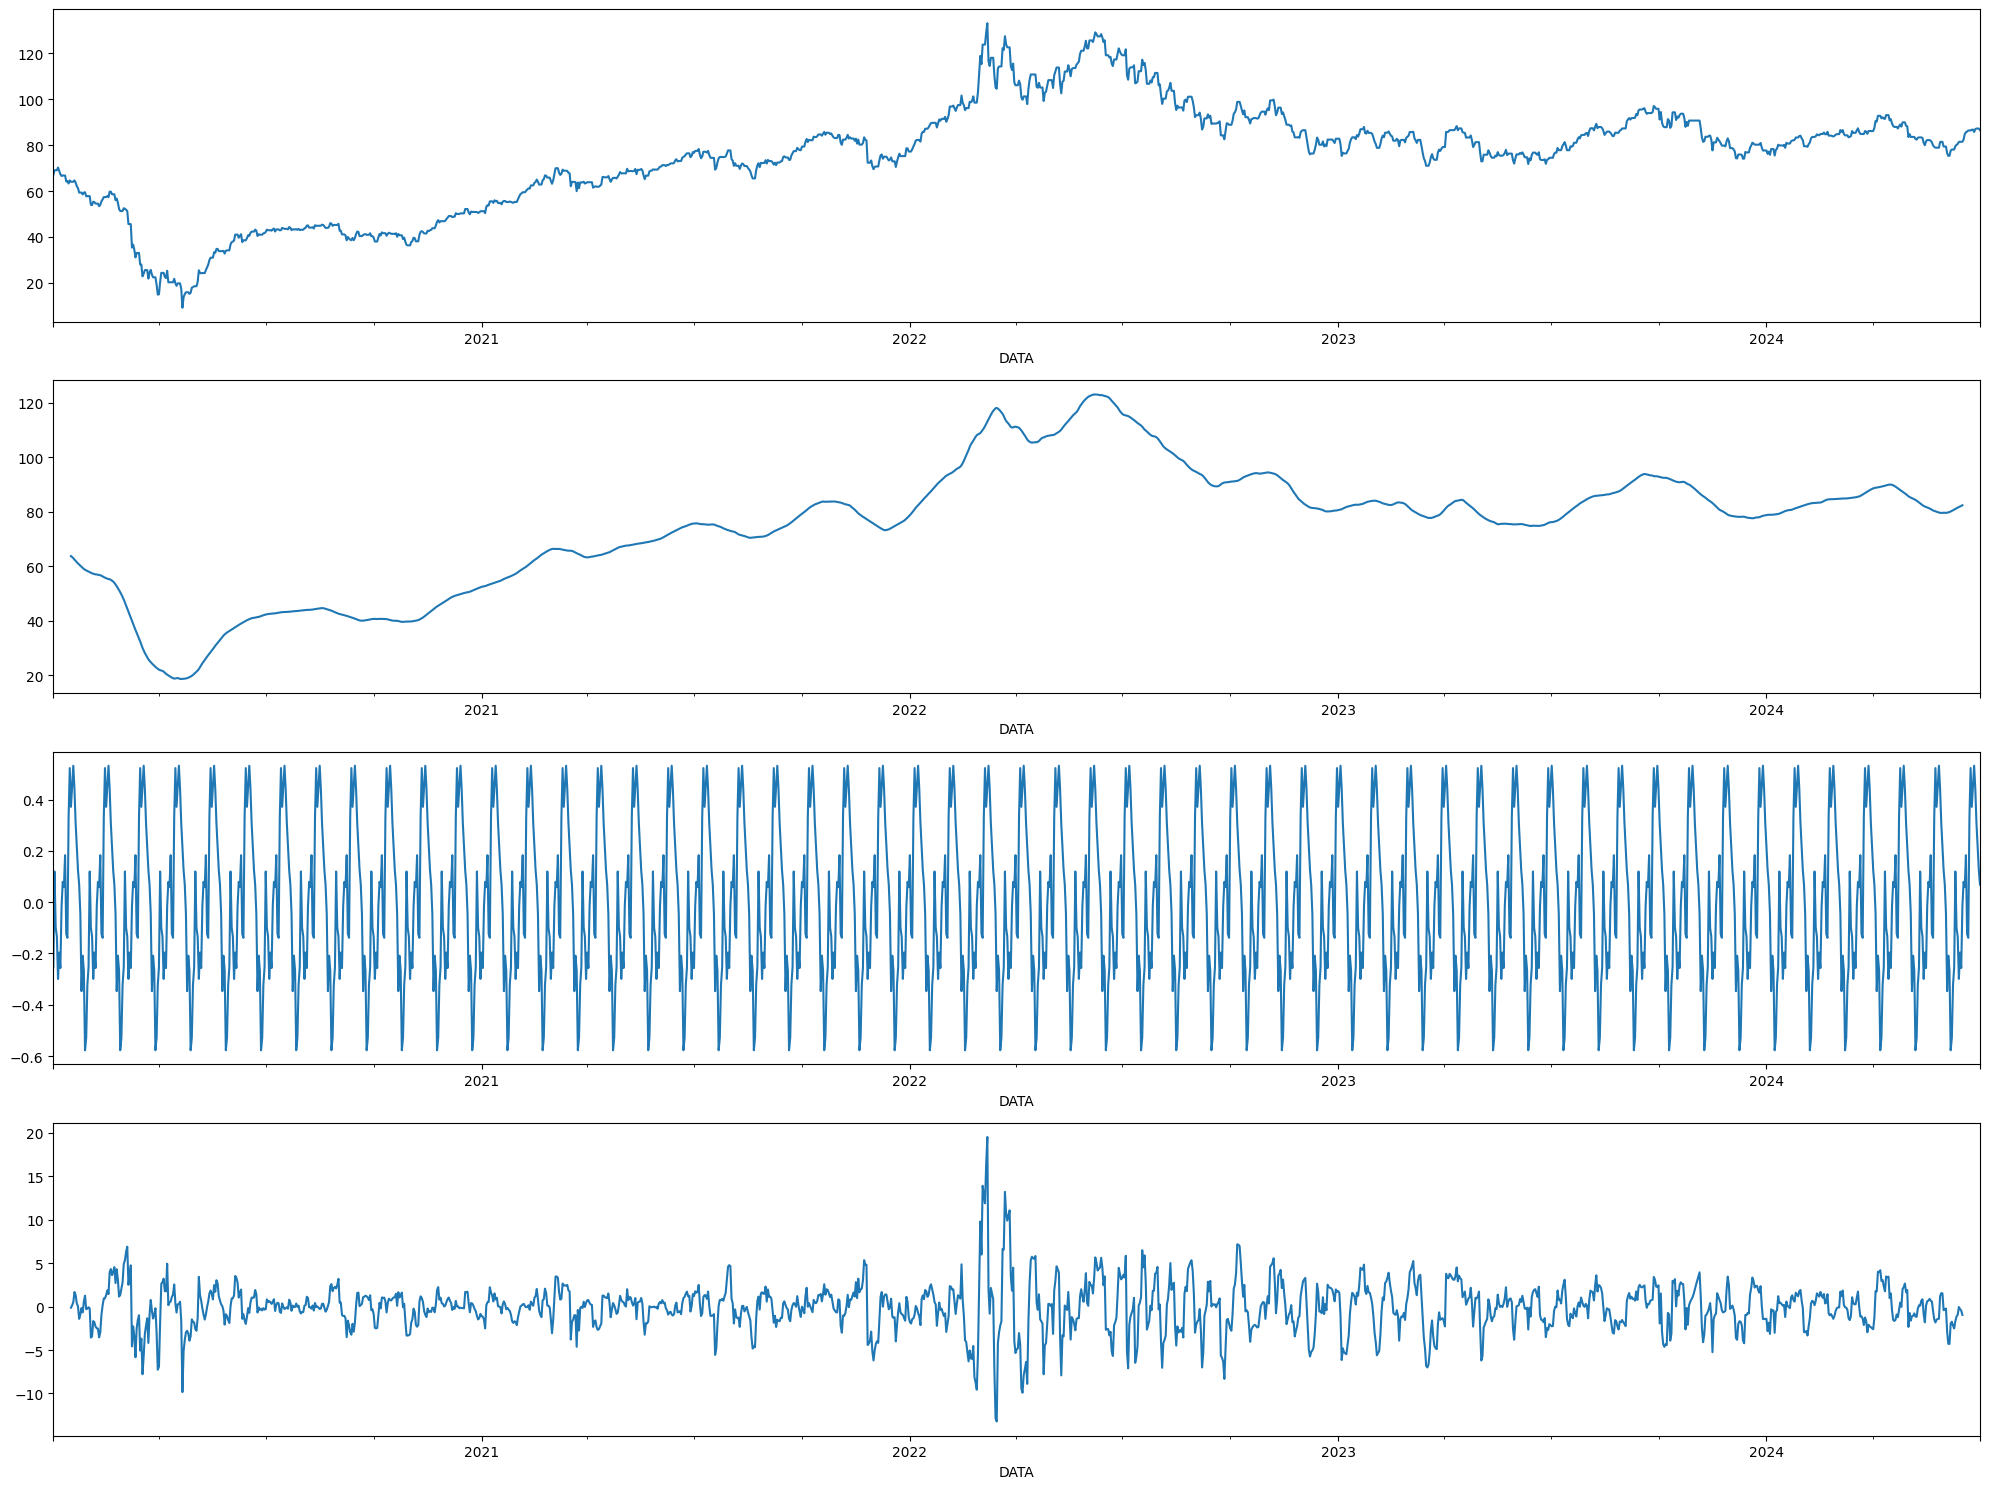

In [21]:
plot_seasonal_decompose(decomposition)

Plotar Rolling Statistics

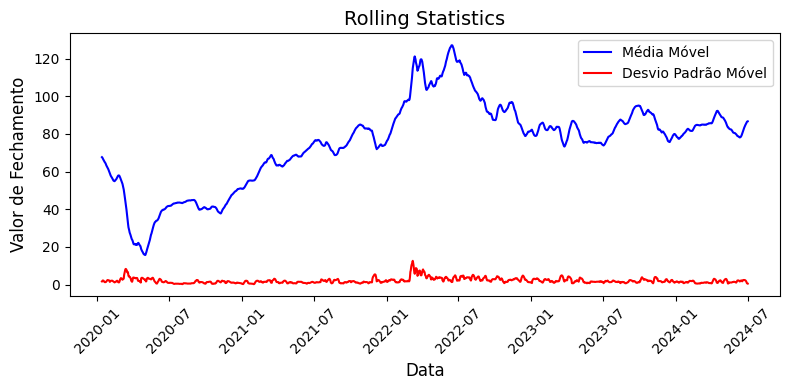

In [23]:
rolmean, rolstd = rolmean_rolstd(df_close_last, 12)

# Plotar Rolling Statistics
plot_rolling_statistics(rolmean, rolstd)


Teste Dickey Fuller

In [24]:
retorno_teste_df = teste_dickey_fuller(df_close_last)   

if retorno_teste_df['p-value'] > 0.05:
      print('A série NÃO é estacionária.')
else:
      print('A série é estacionária.')

Results of Dickey-Fuller Test:
A série NÃO é estacionária.


Transformação Logaritica

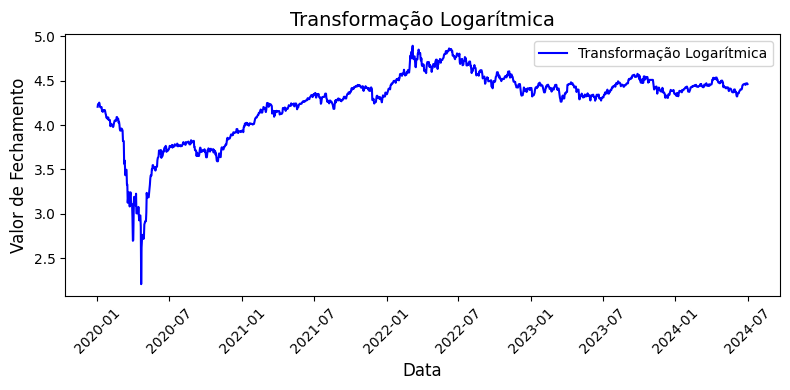

In [25]:
ts_log = transformacao_locaritmica(df_close_last)

# Plota a transformação logaritmica
plot_transformacao_logaritmica(ts_log)

Média Móvel

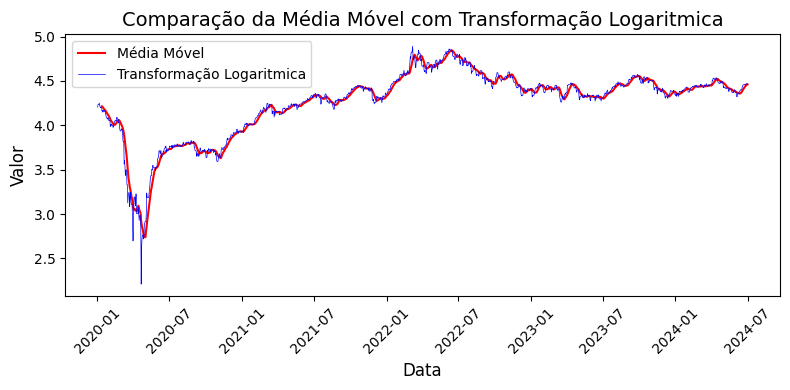

In [26]:
# Média Móvel
moving_avg = media_movel(df_close_last, 12)

# Plota média móvel
plot_media_movel(moving_avg, ts_log)

Plota a subtração da média móvel da série temporal logarítmica

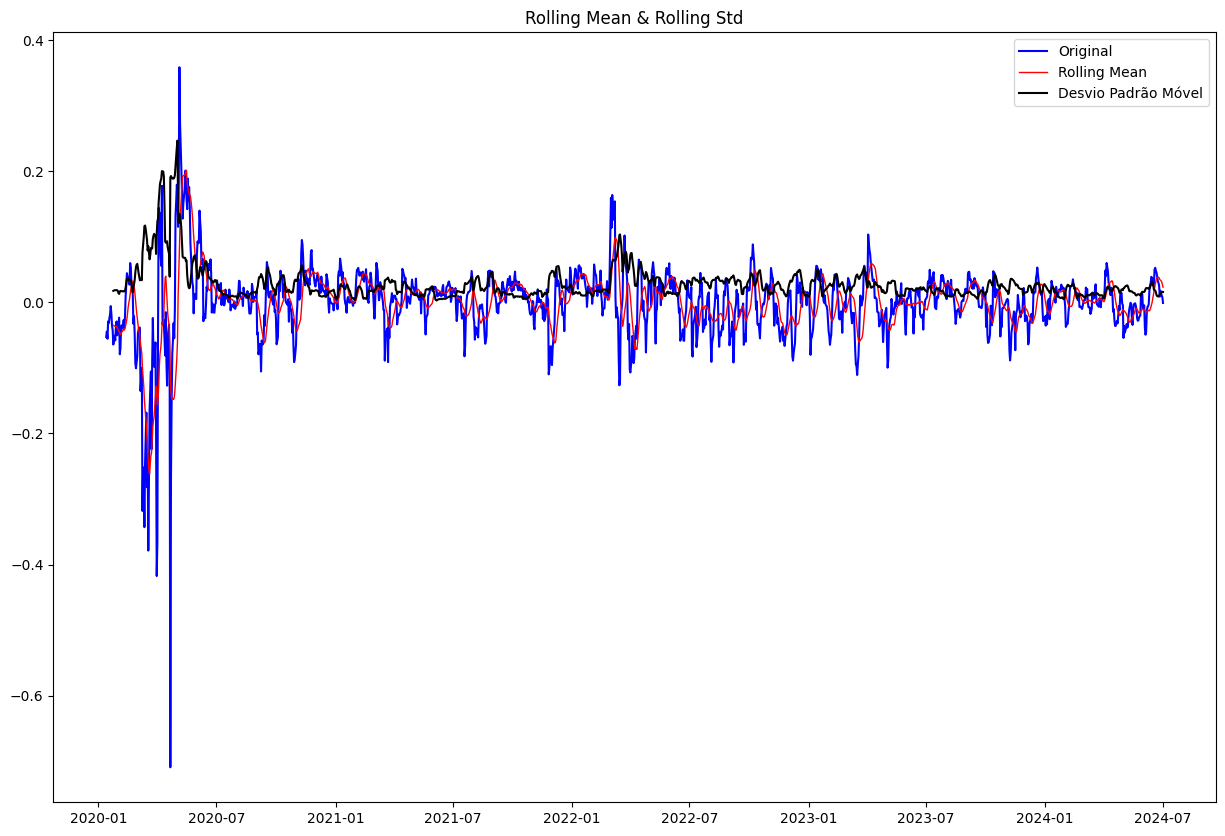

In [27]:
ts_log_moving_avg_diff = subtracao_MV_STL(ts_log, moving_avg)

rolmean, rolstd = rolmean_rolstd(ts_log_moving_avg_diff, 12)

plot_subtracao_MV_STL(ts_log_moving_avg_diff, rolmean, rolstd)

Verificar se a série é estacionária

In [28]:
    
retorno_teste_df = teste_dickey_fuller(ts_log_moving_avg_diff)    

if retorno_teste_df['p-value'] > 0.05:
    print('A série NÃO é estacionária.')
else:
    print('A série é estacionária.')
    df_diff = ts_log_moving_avg_diff.copy()

Results of Dickey-Fuller Test:
A série é estacionária.


Fazer Derivada da Série Temporal

In [29]:

if retorno_teste_df['p-value'] > 0.05:
    
    df_diff = calcula_derivada(ts_log_moving_avg_diff)
    
    rolmean, rolstd = rolmean_rolstd(df_diff, 12)
    
    # Plota a subtração da média móvel da série temporal logarítmica
    plot_subtracao_MV_STL(df_diff, rolmean, rolstd)
    
    retorno_teste_df = teste_dickey_fuller(df_diff)
    
    if retorno_teste_df['p-value'] > 0.05:
        print('A série NÃO é estacionária.')
        sys.exit()
    else:
        print('A série é estacionária.')

Renomear o campo date para ds, campo close para y e criar o campo unique_id

In [30]:

df_modelo = renomeia_colunas(df_diff)

Dividindo os dados em treino e teste

In [31]:
treino, teste, h =  split_treino_teste(df_modelo, dias_treino, dias_teste)

inicio_treino, fim_treino, inicio_teste, fim_teste =  exibir_periodo_datas(treino, teste)

**Treino e Teste naive_model**

In [32]:
model1, forecast_df1 = naive_model(treino, teste, h)

wmape1 = wmape(forecast_df1['y'].values, forecast_df1['Naive'].values)

print(f"{wmape1:.2%}")

if wmape1 <= 0.30:
    print('O modelo é bom.')
else:     
    print('O modelo é ruim.')
    

101.05%
O modelo é ruim.


In [33]:
plot_forecast('Naive', treino, forecast_df1)

**Modelo - AutoARIMA**

In [34]:

h = 10  # Horizonte de previsão

# Rodar o modelo AutoARIMA e gerar previsões
model2, forecast_df2 = auto_arima_model(treino, teste, h)

# Calcular WMAPE
wmape2 = wmape(forecast_df2['y'].values, forecast_df2['AutoARIMA'].values)

print(f"{wmape2:.2%}")

if wmape2 <= 0.30:
    print('O modelo é bom.')
else:
    print('O modelo é ruim.')

# Plotar o gráfico das previsões
plot_forecast('AutoARIMA', treino, forecast_df2)

113.60%
O modelo é ruim.


**Modelo - prophet**

Para o Prophet, utilizar somente dados encontrados e sem a necessidade de transformação estacionária

In [35]:

# Exemplo de uso com o modelo Prophet
df_modelo_prophet = renomeia_colunas(df_close_last)
treino_prophet, teste_prophet, h = split_treino_teste(df_modelo_prophet, dias_treino, dias_teste)


best_params, best_mae = hyperparametros_prophet(treino_prophet)

model3, forecast3, forecast_df3 = prophet_model(
    treino_prophet, 
    teste_prophet, 
    h, 
    best_params['changepoint_prior_scale'], 
    best_params['seasonality_prior_scale']
)

wmape3 = wmape(forecast_df3['y'].values, forecast_df3['yhat'].values)

print(f"{wmape3:.2%}")

if wmape3 <= 0.30:
    print('O modelo é bom.')
else:     
    print('O modelo é ruim.')

21:09:58 - cmdstanpy - INFO - Chain [1] start processing
21:09:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

21:09:58 - cmdstanpy - INFO - Chain [1] start processing
21:09:58 - cmdstanpy - INFO - Chain [1] done processing
21:09:59 - cmdstanpy - INFO - Chain [1] start processing
21:09:59 - cmdstanpy - INFO - Chain [1] done processing
21:09:59 - cmdstanpy - INFO - Chain [1] start processing
21:09:59 - cmdstanpy - INFO - Chain [1] done processing
21:09:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:09:59 - cmdstanpy - INFO - Chain [1] start processing
21:10:00 - cmdstanpy - INFO - Chain [1] done processing
21:10:00 - cmdstanpy - INFO - Chain [1] start processing
21:10:00 - cmdstanpy - INFO - Chain [1] done processing
21:10:00 - cmdstanpy - INFO - Chain [1] start processing
21:10:00 - cmdstanpy - INFO - Chain [1] done processing
21:10:00 - cmdstanpy - INFO - Chain [1] start processing
21:10:00 - cmdstanpy - INFO - Chain [1] done processing
21:10:01 - cmdstanpy - INFO - Chain [1] start process

  0%|          | 0/7 [00:00<?, ?it/s]

21:10:01 - cmdstanpy - INFO - Chain [1] start processing
21:10:01 - cmdstanpy - INFO - Chain [1] done processing
21:10:01 - cmdstanpy - INFO - Chain [1] start processing
21:10:02 - cmdstanpy - INFO - Chain [1] done processing
21:10:02 - cmdstanpy - INFO - Chain [1] start processing
21:10:02 - cmdstanpy - INFO - Chain [1] done processing
21:10:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:10:02 - cmdstanpy - INFO - Chain [1] start processing
21:10:03 - cmdstanpy - INFO - Chain [1] done processing
21:10:03 - cmdstanpy - INFO - Chain [1] start processing
21:10:03 - cmdstanpy - INFO - Chain [1] done processing
21:10:03 - cmdstanpy - INFO - Chain [1] start processing
21:10:03 - cmdstanpy - INFO - Chain [1] done processing
21:10:04 - cmdstanpy - INFO - Chain [1] start processing
21:10:04 - cmdstanpy - INFO - Chain [1] done processing
21:10:04 - cmdstanpy - INFO - Chain [1] start process

  0%|          | 0/7 [00:00<?, ?it/s]

21:10:04 - cmdstanpy - INFO - Chain [1] start processing
21:10:05 - cmdstanpy - INFO - Chain [1] done processing
21:10:05 - cmdstanpy - INFO - Chain [1] start processing
21:10:05 - cmdstanpy - INFO - Chain [1] done processing
21:10:05 - cmdstanpy - INFO - Chain [1] start processing
21:10:05 - cmdstanpy - INFO - Chain [1] done processing
21:10:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:10:05 - cmdstanpy - INFO - Chain [1] start processing
21:10:06 - cmdstanpy - INFO - Chain [1] done processing
21:10:06 - cmdstanpy - INFO - Chain [1] start processing
21:10:06 - cmdstanpy - INFO - Chain [1] done processing
21:10:07 - cmdstanpy - INFO - Chain [1] start processing
21:10:07 - cmdstanpy - INFO - Chain [1] done processing
21:10:07 - cmdstanpy - INFO - Chain [1] start processing
21:10:07 - cmdstanpy - INFO - Chain [1] done processing
21:10:07 - cmdstanpy - INFO - Chain [1] start process

  0%|          | 0/7 [00:00<?, ?it/s]

21:10:08 - cmdstanpy - INFO - Chain [1] start processing
21:10:08 - cmdstanpy - INFO - Chain [1] done processing
21:10:08 - cmdstanpy - INFO - Chain [1] start processing
21:10:08 - cmdstanpy - INFO - Chain [1] done processing
21:10:08 - cmdstanpy - INFO - Chain [1] start processing
21:10:08 - cmdstanpy - INFO - Chain [1] done processing
21:10:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:10:08 - cmdstanpy - INFO - Chain [1] start processing
21:10:09 - cmdstanpy - INFO - Chain [1] done processing
21:10:10 - cmdstanpy - INFO - Chain [1] start processing
21:10:10 - cmdstanpy - INFO - Chain [1] done processing
21:10:10 - cmdstanpy - INFO - Chain [1] start processing
21:10:10 - cmdstanpy - INFO - Chain [1] done processing
21:10:10 - cmdstanpy - INFO - Chain [1] start processing
21:10:10 - cmdstanpy - INFO - Chain [1] done processing
21:10:10 - cmdstanpy - INFO - Chain [1] start process

  0%|          | 0/7 [00:00<?, ?it/s]

21:10:11 - cmdstanpy - INFO - Chain [1] start processing
21:10:11 - cmdstanpy - INFO - Chain [1] done processing
21:10:11 - cmdstanpy - INFO - Chain [1] start processing
21:10:11 - cmdstanpy - INFO - Chain [1] done processing
21:10:12 - cmdstanpy - INFO - Chain [1] start processing
21:10:12 - cmdstanpy - INFO - Chain [1] done processing
21:10:12 - cmdstanpy - INFO - Chain [1] start processing
21:10:12 - cmdstanpy - INFO - Chain [1] done processing
21:10:12 - cmdstanpy - INFO - Chain [1] start processing
21:10:12 - cmdstanpy - INFO - Chain [1] done processing
21:10:12 - cmdstanpy - INFO - Chain [1] start processing
21:10:13 - cmdstanpy - INFO - Chain [1] done processing
21:10:13 - cmdstanpy - INFO - Chain [1] start processing
21:10:13 - cmdstanpy - INFO - Chain [1] done processing
21:10:13 - cmdstanpy - INFO - Chain [1] start processing
21:10:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing i

  0%|          | 0/7 [00:00<?, ?it/s]

21:10:13 - cmdstanpy - INFO - Chain [1] start processing
21:10:13 - cmdstanpy - INFO - Chain [1] done processing
21:10:14 - cmdstanpy - INFO - Chain [1] start processing
21:10:14 - cmdstanpy - INFO - Chain [1] done processing
21:10:14 - cmdstanpy - INFO - Chain [1] start processing
21:10:14 - cmdstanpy - INFO - Chain [1] done processing
21:10:14 - cmdstanpy - INFO - Chain [1] start processing
21:10:14 - cmdstanpy - INFO - Chain [1] done processing
21:10:14 - cmdstanpy - INFO - Chain [1] start processing
21:10:15 - cmdstanpy - INFO - Chain [1] done processing
21:10:15 - cmdstanpy - INFO - Chain [1] start processing
21:10:15 - cmdstanpy - INFO - Chain [1] done processing
21:10:15 - cmdstanpy - INFO - Chain [1] start processing
21:10:15 - cmdstanpy - INFO - Chain [1] done processing
21:10:15 - cmdstanpy - INFO - Chain [1] start processing
21:10:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing i

  0%|          | 0/7 [00:00<?, ?it/s]

21:10:16 - cmdstanpy - INFO - Chain [1] start processing
21:10:16 - cmdstanpy - INFO - Chain [1] done processing
21:10:16 - cmdstanpy - INFO - Chain [1] start processing
21:10:16 - cmdstanpy - INFO - Chain [1] done processing
21:10:16 - cmdstanpy - INFO - Chain [1] start processing
21:10:16 - cmdstanpy - INFO - Chain [1] done processing
21:10:16 - cmdstanpy - INFO - Chain [1] start processing
21:10:17 - cmdstanpy - INFO - Chain [1] done processing
21:10:17 - cmdstanpy - INFO - Chain [1] start processing
21:10:17 - cmdstanpy - INFO - Chain [1] done processing
21:10:17 - cmdstanpy - INFO - Chain [1] start processing
21:10:17 - cmdstanpy - INFO - Chain [1] done processing
21:10:17 - cmdstanpy - INFO - Chain [1] start processing
21:10:17 - cmdstanpy - INFO - Chain [1] done processing
21:10:18 - cmdstanpy - INFO - Chain [1] start processing
21:10:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing i

  0%|          | 0/7 [00:00<?, ?it/s]

21:10:18 - cmdstanpy - INFO - Chain [1] start processing
21:10:18 - cmdstanpy - INFO - Chain [1] done processing
21:10:18 - cmdstanpy - INFO - Chain [1] start processing
21:10:18 - cmdstanpy - INFO - Chain [1] done processing
21:10:18 - cmdstanpy - INFO - Chain [1] start processing
21:10:19 - cmdstanpy - INFO - Chain [1] done processing
21:10:19 - cmdstanpy - INFO - Chain [1] start processing
21:10:19 - cmdstanpy - INFO - Chain [1] done processing
21:10:19 - cmdstanpy - INFO - Chain [1] start processing
21:10:19 - cmdstanpy - INFO - Chain [1] done processing
21:10:19 - cmdstanpy - INFO - Chain [1] start processing
21:10:19 - cmdstanpy - INFO - Chain [1] done processing
21:10:20 - cmdstanpy - INFO - Chain [1] start processing
21:10:20 - cmdstanpy - INFO - Chain [1] done processing
21:10:20 - cmdstanpy - INFO - Chain [1] start processing
21:10:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing i

  0%|          | 0/7 [00:00<?, ?it/s]

21:10:20 - cmdstanpy - INFO - Chain [1] start processing
21:10:21 - cmdstanpy - INFO - Chain [1] done processing
21:10:21 - cmdstanpy - INFO - Chain [1] start processing
21:10:21 - cmdstanpy - INFO - Chain [1] done processing
21:10:21 - cmdstanpy - INFO - Chain [1] start processing
21:10:21 - cmdstanpy - INFO - Chain [1] done processing
21:10:21 - cmdstanpy - INFO - Chain [1] start processing
21:10:21 - cmdstanpy - INFO - Chain [1] done processing
21:10:22 - cmdstanpy - INFO - Chain [1] start processing
21:10:22 - cmdstanpy - INFO - Chain [1] done processing
21:10:22 - cmdstanpy - INFO - Chain [1] start processing
21:10:22 - cmdstanpy - INFO - Chain [1] done processing
21:10:22 - cmdstanpy - INFO - Chain [1] start processing
21:10:23 - cmdstanpy - INFO - Chain [1] done processing
21:10:23 - cmdstanpy - INFO - Chain [1] start processing
21:10:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing i

  0%|          | 0/7 [00:00<?, ?it/s]

21:10:23 - cmdstanpy - INFO - Chain [1] start processing
21:10:23 - cmdstanpy - INFO - Chain [1] done processing
21:10:23 - cmdstanpy - INFO - Chain [1] start processing
21:10:24 - cmdstanpy - INFO - Chain [1] done processing
21:10:24 - cmdstanpy - INFO - Chain [1] start processing
21:10:24 - cmdstanpy - INFO - Chain [1] done processing
21:10:24 - cmdstanpy - INFO - Chain [1] start processing
21:10:24 - cmdstanpy - INFO - Chain [1] done processing
21:10:24 - cmdstanpy - INFO - Chain [1] start processing
21:10:25 - cmdstanpy - INFO - Chain [1] done processing
21:10:25 - cmdstanpy - INFO - Chain [1] start processing
21:10:25 - cmdstanpy - INFO - Chain [1] done processing
21:10:25 - cmdstanpy - INFO - Chain [1] start processing
21:10:25 - cmdstanpy - INFO - Chain [1] done processing
21:10:26 - cmdstanpy - INFO - Chain [1] start processing
21:10:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing i

  0%|          | 0/7 [00:00<?, ?it/s]

21:10:26 - cmdstanpy - INFO - Chain [1] start processing
21:10:26 - cmdstanpy - INFO - Chain [1] done processing
21:10:26 - cmdstanpy - INFO - Chain [1] start processing
21:10:26 - cmdstanpy - INFO - Chain [1] done processing
21:10:27 - cmdstanpy - INFO - Chain [1] start processing
21:10:27 - cmdstanpy - INFO - Chain [1] done processing
21:10:27 - cmdstanpy - INFO - Chain [1] start processing
21:10:27 - cmdstanpy - INFO - Chain [1] done processing
21:10:27 - cmdstanpy - INFO - Chain [1] start processing
21:10:27 - cmdstanpy - INFO - Chain [1] done processing
21:10:28 - cmdstanpy - INFO - Chain [1] start processing
21:10:28 - cmdstanpy - INFO - Chain [1] done processing
21:10:28 - cmdstanpy - INFO - Chain [1] start processing
21:10:28 - cmdstanpy - INFO - Chain [1] done processing
21:10:28 - cmdstanpy - INFO - Chain [1] start processing
21:10:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing i

  0%|          | 0/7 [00:00<?, ?it/s]

21:10:29 - cmdstanpy - INFO - Chain [1] start processing
21:10:29 - cmdstanpy - INFO - Chain [1] done processing
21:10:29 - cmdstanpy - INFO - Chain [1] start processing
21:10:29 - cmdstanpy - INFO - Chain [1] done processing
21:10:29 - cmdstanpy - INFO - Chain [1] start processing
21:10:29 - cmdstanpy - INFO - Chain [1] done processing
21:10:30 - cmdstanpy - INFO - Chain [1] start processing
21:10:30 - cmdstanpy - INFO - Chain [1] done processing
21:10:30 - cmdstanpy - INFO - Chain [1] start processing
21:10:30 - cmdstanpy - INFO - Chain [1] done processing
21:10:30 - cmdstanpy - INFO - Chain [1] start processing
21:10:31 - cmdstanpy - INFO - Chain [1] done processing
21:10:31 - cmdstanpy - INFO - Chain [1] start processing
21:10:31 - cmdstanpy - INFO - Chain [1] done processing
21:10:31 - cmdstanpy - INFO - Chain [1] start processing
21:10:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing i

  0%|          | 0/7 [00:00<?, ?it/s]

21:10:32 - cmdstanpy - INFO - Chain [1] start processing
21:10:32 - cmdstanpy - INFO - Chain [1] done processing
21:10:32 - cmdstanpy - INFO - Chain [1] start processing
21:10:32 - cmdstanpy - INFO - Chain [1] done processing
21:10:33 - cmdstanpy - INFO - Chain [1] start processing
21:10:33 - cmdstanpy - INFO - Chain [1] done processing
21:10:33 - cmdstanpy - INFO - Chain [1] start processing
21:10:33 - cmdstanpy - INFO - Chain [1] done processing
21:10:33 - cmdstanpy - INFO - Chain [1] start processing
21:10:34 - cmdstanpy - INFO - Chain [1] done processing
21:10:34 - cmdstanpy - INFO - Chain [1] start processing
21:10:34 - cmdstanpy - INFO - Chain [1] done processing
21:10:34 - cmdstanpy - INFO - Chain [1] start processing
21:10:35 - cmdstanpy - INFO - Chain [1] done processing
21:10:35 - cmdstanpy - INFO - Chain [1] start processing
21:10:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing i

  0%|          | 0/7 [00:00<?, ?it/s]

21:10:36 - cmdstanpy - INFO - Chain [1] start processing
21:10:36 - cmdstanpy - INFO - Chain [1] done processing
21:10:36 - cmdstanpy - INFO - Chain [1] start processing
21:10:36 - cmdstanpy - INFO - Chain [1] done processing
21:10:36 - cmdstanpy - INFO - Chain [1] start processing
21:10:37 - cmdstanpy - INFO - Chain [1] done processing
21:10:37 - cmdstanpy - INFO - Chain [1] start processing
21:10:37 - cmdstanpy - INFO - Chain [1] done processing
21:10:37 - cmdstanpy - INFO - Chain [1] start processing
21:10:38 - cmdstanpy - INFO - Chain [1] done processing
21:10:38 - cmdstanpy - INFO - Chain [1] start processing
21:10:38 - cmdstanpy - INFO - Chain [1] done processing
21:10:38 - cmdstanpy - INFO - Chain [1] start processing
21:10:39 - cmdstanpy - INFO - Chain [1] done processing
21:10:39 - cmdstanpy - INFO - Chain [1] start processing
21:10:40 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing i

  0%|          | 0/7 [00:00<?, ?it/s]

21:10:40 - cmdstanpy - INFO - Chain [1] start processing
21:10:40 - cmdstanpy - INFO - Chain [1] done processing
21:10:40 - cmdstanpy - INFO - Chain [1] start processing
21:10:40 - cmdstanpy - INFO - Chain [1] done processing
21:10:41 - cmdstanpy - INFO - Chain [1] start processing
21:10:41 - cmdstanpy - INFO - Chain [1] done processing
21:10:41 - cmdstanpy - INFO - Chain [1] start processing
21:10:41 - cmdstanpy - INFO - Chain [1] done processing
21:10:41 - cmdstanpy - INFO - Chain [1] start processing
21:10:42 - cmdstanpy - INFO - Chain [1] done processing
21:10:42 - cmdstanpy - INFO - Chain [1] start processing
21:10:42 - cmdstanpy - INFO - Chain [1] done processing
21:10:42 - cmdstanpy - INFO - Chain [1] start processing
21:10:43 - cmdstanpy - INFO - Chain [1] done processing
21:10:43 - cmdstanpy - INFO - Chain [1] start processing
21:10:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing i

  0%|          | 0/7 [00:00<?, ?it/s]

21:10:44 - cmdstanpy - INFO - Chain [1] start processing
21:10:44 - cmdstanpy - INFO - Chain [1] done processing
21:10:44 - cmdstanpy - INFO - Chain [1] start processing
21:10:44 - cmdstanpy - INFO - Chain [1] done processing
21:10:44 - cmdstanpy - INFO - Chain [1] start processing
21:10:45 - cmdstanpy - INFO - Chain [1] done processing
21:10:45 - cmdstanpy - INFO - Chain [1] start processing
21:10:45 - cmdstanpy - INFO - Chain [1] done processing
21:10:45 - cmdstanpy - INFO - Chain [1] start processing
21:10:46 - cmdstanpy - INFO - Chain [1] done processing
21:10:46 - cmdstanpy - INFO - Chain [1] start processing
21:10:46 - cmdstanpy - INFO - Chain [1] done processing
21:10:46 - cmdstanpy - INFO - Chain [1] start processing
21:10:47 - cmdstanpy - INFO - Chain [1] done processing
21:10:47 - cmdstanpy - INFO - Chain [1] start processing
21:10:48 - cmdstanpy - INFO - Chain [1] done processing


5.70%
O modelo é bom.


In [36]:
# Plotar o gráfico das previsões do modelo Prophet
plot_forecast_prophet('Prophet', treino_prophet, forecast_df3, forecast_col='yhat')


In [51]:
df_futuro = model3.make_future_dataframe(periods=30, freq='D')
previsao = model3.predict(df_futuro)
previsao

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2021-05-15,65.133544,62.147356,70.419978,65.133544,65.133544,0.024414,0.024414,0.024414,0.021931,0.021931,0.021931,0.001264,0.001264,0.001264,-0.003747,-0.003747,-0.003747,0.0,0.0,0.0,66.562009
1,2021-05-16,65.302771,62.800138,70.531928,65.302771,65.302771,0.024414,0.024414,0.024414,0.023120,0.023120,0.023120,0.001265,0.001265,0.001265,-0.002560,-0.002560,-0.002560,0.0,0.0,0.0,66.812561
2,2021-05-17,65.471998,63.282129,71.140921,65.471998,65.471998,0.024414,0.024414,0.024414,0.024507,0.024507,0.024507,0.001324,0.001324,0.001324,-0.001231,-0.001231,-0.001231,0.0,0.0,0.0,67.076528
3,2021-05-18,65.641225,63.387329,71.456976,65.641225,65.641225,0.024414,0.024414,0.024414,0.024503,0.024503,0.024503,-0.000119,-0.000119,-0.000119,0.000209,0.000209,0.000209,0.0,0.0,0.0,67.249662
4,2021-05-19,65.810452,63.108776,71.538274,65.810452,65.810452,0.024414,0.024414,0.024414,0.023399,0.023399,0.023399,-0.002745,-0.002745,-0.002745,0.001730,0.001730,0.001730,0.0,0.0,0.0,67.350320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1125,2024-06-13,82.674075,81.318433,91.631560,79.899856,85.072011,0.024414,0.024414,0.024414,0.046647,0.046647,0.046647,-0.002471,-0.002471,-0.002471,0.024704,0.024704,0.024704,0.0,0.0,0.0,86.530562
1126,2024-06-14,82.671160,81.056125,92.149152,79.578125,85.269487,0.024414,0.024414,0.024414,0.050671,0.050671,0.050671,0.001483,0.001483,0.001483,0.024774,0.024774,0.024774,0.0,0.0,0.0,86.860190
1127,2024-06-15,82.668244,81.517018,92.244442,79.302040,85.548237,0.024414,0.024414,0.024414,0.050459,0.050459,0.050459,0.001264,0.001264,0.001264,0.024781,0.024781,0.024781,0.0,0.0,0.0,86.839625
1128,2024-06-16,82.665329,80.900508,92.482985,79.029361,85.872300,0.024414,0.024414,0.024414,0.050399,0.050399,0.050399,0.001265,0.001265,0.001265,0.024720,0.024720,0.024720,0.0,0.0,0.0,86.831576


In [38]:
dif = calcular_e_exibir_diferenca(forecast_df3)

# Exibe o DataFrame
print("Diferença Percentual Absoluta entre Valores Reais e Previstos:")
dif

Diferença Percentual Absoluta entre Valores Reais e Previstos:


,Data,Valor Real,Valor Previsto,Diferença Percentual (%)
0,2024-05-19,82.24,85.047206,3.300762
1,2024-05-20,81.91,85.180036,3.838969
2,2024-05-21,81.22,85.190221,4.660418
3,2024-05-22,79.90,85.102187,6.112871
4,2024-05-23,79.25,85.251939,7.040237
5,2024-05-24,78.92,85.702487,7.913991
6,2024-05-25,78.92,85.802896,8.021752
7,2024-05-26,78.92,85.915469,8.142269
8,2024-05-27,78.92,86.026158,8.260462
9,2024-05-28,81.34,86.005433,5.424579


**Gerando Modelo**

In [39]:
import joblib  
import os  

# Definindo o caminho da pasta
pasta_destino = './models/model_teste/'

caminho_completo = os.path.join(pasta_destino, 'modelo_treinado.pkl')

joblib.dump(model3, caminho_completo)

['./models/model_teste/modelo_treinado.pkl']

**Carrega o modelo treinado**

In [54]:

caminho_modelo = './models/model_teste/modelo_treinado.pkl'

modelo = joblib.load(caminho_modelo)
predicoes = modelo.predict(df_modelo)

dif = calcular_e_exibir_diferenca_pkl(forecast_df3)

print("Valores e Previstos:")

# Exibe o DataFrame
dif.tail(10)

Valores e Previstos:


,Data,Valor Previsto
34,2024-06-22,86.652175
35,2024-06-23,86.600188
36,2024-06-24,86.547380
37,2024-06-25,86.365467
38,2024-06-26,86.081631
39,2024-06-27,86.034186
40,2024-06-28,86.288680
41,2024-06-29,86.197457
42,2024-06-30,86.124678
43,2024-07-01,86.058413
